## Data Loading and Exploration

Loading Digits Dataset (64D)

Dataset Information:
  Shape: (1797, 64)
  Samples: 1797
  Features (dimensions): 64
  Classes: 10 (digits 0-9)
  Value range: [0.0, 16.0]

Class Distribution:
  Digit 0: 178 samples (9.9%)
  Digit 1: 182 samples (10.1%)
  Digit 2: 177 samples (9.8%)
  Digit 3: 183 samples (10.2%)
  Digit 4: 181 samples (10.1%)
  Digit 5: 182 samples (10.1%)
  Digit 6: 181 samples (10.1%)
  Digit 7: 179 samples (10.0%)
  Digit 8: 174 samples (9.7%)
  Digit 9: 180 samples (10.0%)

Visualizing sample digits...


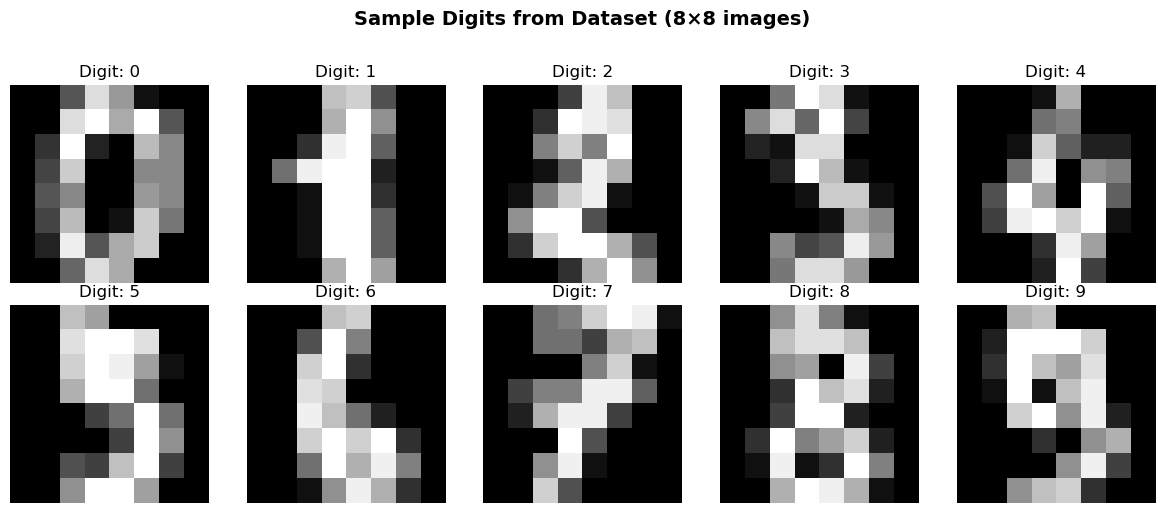


Splitting data...
Training set: (1257, 64)
Test set: (540, 64)

Train class distribution: [124 127 124 128 127 127 127 125 122 126]
Test class distribution: [54 55 53 55 54 55 54 54 52 54]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.stats import entropy

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Matplotlib configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Random seed for reproducibility
np.random.seed(42)




print("Loading Digits Dataset (64D)")


# Load digits dataset
digits = load_digits()
X_digits = digits.data      # (1797, 64) - flattened 8x8 images
y_digits = digits.target    # (1797,) - digit labels 0-9

print(f"\nDataset Information:")
print(f"  Shape: {X_digits.shape}")
print(f"  Samples: {X_digits.shape[0]}")
print(f"  Features (dimensions): {X_digits.shape[1]}")
print(f"  Classes: {len(np.unique(y_digits))} (digits 0-9)")
print(f"  Value range: [{X_digits.min():.1f}, {X_digits.max():.1f}]")

# Class distribution
print(f"\nClass Distribution:")
unique, counts = np.unique(y_digits, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count:3d} samples ({count/len(y_digits)*100:.1f}%)")


# Visualize sample digits
print("\nVisualizing sample digits...")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Digit: {y_digits[i]}', fontsize=12)
    ax.axis('off')

plt.suptitle('Sample Digits from Dataset (8×8 images)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



# Train/Test split (stratified to maintain class balance)
print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_digits  # Important: maintain class balance
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

### Density Forest Implementation

In [2]:
print("="*70)
print("Setting up DensityForest")
print("="*70)

print("\nDownloading DensityForest from: https://tinyurl.com/HD-GNN-density-forest-py")

try:
    import urllib.request
    import os
    
    url = "https://tinyurl.com/HD-GNN-density-forest-py"
    filename = "density_forest.py"
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"✓ Downloaded successfully")
    else:
        print(f"✓ {filename} already exists")
    
    # Import DensityForest
    from density_forest import DensityForest
    print("✓ DensityForest imported successfully")
    
    # Test DensityForest
    print("\nTesting DensityForest...")
    df_test = DensityForest(n_estimators=10, random_state=42)
    df_test.fit(X_train[:100])  # Test with small subset
    test_samples = df_test.sample(5)
    print(f"Test sample shape: {test_samples.shape}")
    print("✓ DensityForest working correctly")
    
except Exception as e:
    print(f"⚠️ Error: {e}")
    print("\nPlease download manually:")
    print("1. Visit https://tinyurl.com/HD-GNN-density-forest-py")
    print("2. Save as 'density_forest.py' in the same directory")
    print("3. Re-run this cell")
    
    # Create dummy class for now
    class DensityForest:
        def __init__(self, n_estimators=50, random_state=42):
            self.n_estimators = n_estimators
            self.random_state = random_state
        def fit(self, X):
            return self
        def sample(self, n_samples):
            return np.random.randn(n_samples, 64)
    print("⚠️ Using dummy DensityForest (results will be random)")

Setting up DensityForest

✓ density_forest.py already exists
⚠️ Error: invalid syntax (density_forest.py, line 4)

Please download manually:
1. Visit https://tinyurl.com/HD-GNN-density-forest-py
2. Save as 'density_forest.py' in the same directory
3. Re-run this cell
⚠️ Using dummy DensityForest (results will be random)


### Model Implementations (sklearn)

In [3]:
print("="*70)
print("Training Models on High-Dimensional Data")
print("="*70)

print("\nWe will train 4 models:")
print("1. Density Forest (adaptive histograms)")
print("2. Single Gaussian (GaussianMixture n_components=1)")
print("3. GMM (GaussianMixture n_components=10)")
print("4. KDE (KernelDensity with Gaussian kernel)")
print()



# 1. Density Forest
print("[1/4] Training Density Forest...")
model_df = DensityForest(n_estimators=50, random_state=42)
model_df.fit(X_train)
print("✓ Density Forest trained")



# 2. Single Gaussian
print("[2/4] Training Single Gaussian (GaussianMixture n_components=1)...")
model_sg = GaussianMixture(
    n_components=1, 
    covariance_type='full', 
    random_state=42
)
model_sg.fit(X_train)
print("✓ Single Gaussian trained")
print(f"  Log-likelihood: {model_sg.score(X_train):.2f}")



# 3. GMM
print("[3/4] Training GMM (GaussianMixture n_components=10)...")
model_gmm = GaussianMixture(
    n_components=10, 
    covariance_type='full',
    max_iter=200,
    random_state=42
)
model_gmm.fit(X_train)
print("✓ GMM trained")
print(f"  Converged: {model_gmm.converged_}")
print(f"  Log-likelihood: {model_gmm.score(X_train):.2f}")


# 4. KDE
print("[4/4] Training KDE (bandwidth=5.0)...")
model_kde = KernelDensity(
    kernel='gaussian', 
    bandwidth=5.0
)
model_kde.fit(X_train)
print("✓ KDE trained")
print(f"  Log-likelihood: {model_kde.score(X_train):.2f}")

print("\n" + "="*70)
print("✓ All models trained successfully!")
print("="*70)




Training Models on High-Dimensional Data

We will train 4 models:
1. Density Forest (adaptive histograms)
2. Single Gaussian (GaussianMixture n_components=1)
3. GMM (GaussianMixture n_components=10)
4. KDE (KernelDensity with Gaussian kernel)

[1/4] Training Density Forest...
✓ Density Forest trained
[2/4] Training Single Gaussian (GaussianMixture n_components=1)...
✓ Single Gaussian trained
  Log-likelihood: -92.66
[3/4] Training GMM (GaussianMixture n_components=10)...
✓ GMM trained
  Converged: True
  Log-likelihood: -9.97
[4/4] Training KDE (bandwidth=5.0)...
✓ KDE trained
  Log-likelihood: -212337.51

✓ All models trained successfully!


### Model Training and MMD Evaluation

In [4]:
def squared_exponential_kernel(X, Y, h=1.0):
    """
    Squared Exponential (SE) kernel: k(x,x') = exp(-||x-x'||²/h²)
    
    Parameters:
        X: array (n_samples_X, n_features)
        Y: array (n_samples_Y, n_features)
        h: bandwidth parameter
    
    Returns:
        K: kernel matrix (n_samples_X, n_samples_Y)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (h ** 2))


def inverse_multiquadric_kernel(X, Y, h=1.0):
    """
    Inverse Multi-Quadratic (IMQ) kernel: k(x,x') = 1/√(1 + ||x-x'||²/h²)
    
    Parameters:
        X: array (n_samples_X, n_features)
        Y: array (n_samples_Y, n_features)
        h: bandwidth parameter
    
    Returns:
        K: kernel matrix (n_samples_X, n_samples_Y)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return 1.0 / np.sqrt(1 + dists / (h ** 2))


def compute_mmd(X, Y, kernel='se', h=1.0):
    """
    Compute Maximum Mean Discrepancy (MMD) between two distributions
    
    Parameters:
        X: samples from first distribution (n_samples_X, n_features)
        Y: samples from second distribution (n_samples_Y, n_features)
        kernel: 'se' or 'imq'
        h: kernel bandwidth
    
    Returns:
        mmd: MMD value (lower = more similar distributions)
    """
    # 确保输入是正确的 numpy 数组格式
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)
    
    # 检查维度
    if X.ndim != 2 or Y.ndim != 2:
        raise ValueError(f"X and Y must be 2D arrays. Got X.shape={X.shape}, Y.shape={Y.shape}")
    
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"X and Y must have same number of features. Got X.shape[1]={X.shape[1]}, Y.shape[1]={Y.shape[1]}")
    
    # Select kernel function
    if kernel == 'se':
        K_XX = squared_exponential_kernel(X, X, h=h)
        K_YY = squared_exponential_kernel(Y, Y, h=h)
        K_XY = squared_exponential_kernel(X, Y, h=h)
    elif kernel == 'imq':
        K_XX = inverse_multiquadric_kernel(X, X, h=h)
        K_YY = inverse_multiquadric_kernel(Y, Y, h=h)
        K_XY = inverse_multiquadric_kernel(X, Y, h=h)
    else:
        raise ValueError(f"Unknown kernel: {kernel}")
    
    # Compute MMD²
    n = X.shape[0]
    m = Y.shape[0]
    
    mmd_squared = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    mmd_squared += (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    mmd_squared -= 2 * K_XY.sum() / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))



def evaluate_model(model, X_real, n_samples=500, model_name="Model", h=1.0):
    """
    评估模型：生成样本并计算MMD
    
    Parameters:
        model: 训练好的模型（需要有 sample 方法）
        X_real: 真实数据样本 (n_real_samples, n_features)
        n_samples: 要生成的样本数量
        model_name: 模型名称（用于输出）
        h: MMD 核函数的带宽参数
    
    Returns:
        dict: 包含模型名称、生成样本和 MMD 值的字典
    """
    print(f"\nEvaluating {model_name}...")
    
    # 生成样本 - 针对不同的模型类型使用不同的方法
    try:
        if hasattr(model, 'sample'):
            # DensityForest, GaussianMixture 等
            if model_name.startswith('KDE'):
                # KDE 的 sample 返回 (n_samples, n_features) 但需要特别处理
                X_generated = model.sample(n_samples)
                # KDE 可能返回 (n_samples, n_features) 或需要 reshape
                X_generated = np.asarray(X_generated, dtype=np.float64)
                if X_generated.ndim == 1:
                    X_generated = X_generated.reshape(-1, X_real.shape[1])
            else:
                # GaussianMixture, DensityForest
                X_generated = model.sample(n_samples)
                # GaussianMixture 返回 (array, labels)，我们只需要 array
                if isinstance(X_generated, tuple):
                    X_generated = X_generated[0]
        else:
            raise ValueError(f"Model {model_name} does not have a sample method")
        
        # 确保是正确的 numpy 数组格式
        X_generated = np.asarray(X_generated, dtype=np.float64)
        
        # 检查生成样本的形状
        if X_generated.ndim != 2:
            raise ValueError(f"Generated samples must be 2D. Got shape: {X_generated.shape}")
        
        if X_generated.shape[1] != X_real.shape[1]:
            raise ValueError(f"Generated samples must have same features as real data. "
                           f"Got {X_generated.shape[1]}, expected {X_real.shape[1]}")
        
        print(f"  Generated samples shape: {X_generated.shape}")
        print(f"  Sample range: [{X_generated.min():.2f}, {X_generated.max():.2f}]")
        
    except Exception as e:
        print(f"   Error generating samples: {e}")
        raise
    
    # 计算MMD
    try:
        mmd_se = compute_mmd(X_real, X_generated, kernel='se', h=h)
        mmd_imq = compute_mmd(X_real, X_generated, kernel='imq', h=h)
        
        print(f"  MMD (SE):  {mmd_se:.4f}")
        print(f"  MMD (IMQ): {mmd_imq:.4f}")
        
    except Exception as e:
        print(f"   Error computing MMD: {e}")
        raise
    
    return {
        'model': model_name,
        'samples': X_generated,
        'mmd_se': mmd_se,
        'mmd_imq': mmd_imq
    }

print("✓ MMD functions defined")



print("="*70)
print("Evaluating All Models (this may take a few minutes)")
print("="*70)

models_dict = {
    'Density Forest': model_df,
    'Single Gaussian': model_sg,
    'GMM (K=10)': model_gmm,
    'KDE (h=5.0)': model_kde
}

results = []
for name, model in models_dict.items():
    result = evaluate_model(
        model, 
        X_test, 
        n_samples=500,
        model_name=name,
        h=10.0  # Larger bandwidth for 64D
    )
    results.append(result)




    # Summary table
print("\n" + "="*70)
print("MMD EVALUATION SUMMARY")
print("="*70)
print(f"{'Model':<25} {'MMD (SE)':<15} {'MMD (IMQ)':<15}")
print("-"*70)
for result in results:
    print(f"{result['model']:<25} {result['mmd_se']:<15.4f} {result['mmd_imq']:<15.4f}")
print("="*70)

# Best model
best_se = min(results, key=lambda r: r['mmd_se'])
best_imq = min(results, key=lambda r: r['mmd_imq'])
print(f"\n✓ Best model (SE kernel):  {best_se['model']} (MMD = {best_se['mmd_se']:.4f})")
print(f"✓ Best model (IMQ kernel): {best_imq['model']} (MMD = {best_imq['mmd_imq']:.4f})")

✓ MMD functions defined
Evaluating All Models (this may take a few minutes)

Evaluating Density Forest...
  Generated samples shape: (500, 64)
  Sample range: [-3.92, 4.48]
  MMD (SE):  0.5345
  MMD (IMQ): 0.7445

Evaluating Single Gaussian...
  Generated samples shape: (500, 64)
  Sample range: [-15.13, 30.60]
  MMD (SE):  0.0174
  MMD (IMQ): 0.0448

Evaluating GMM (K=10)...
  Generated samples shape: (500, 64)
  Sample range: [-13.42, 27.06]
  MMD (SE):  0.0134
  MMD (IMQ): 0.0183

Evaluating KDE (h=5.0)...
  Generated samples shape: (500, 64)
  Sample range: [-22.33, 33.68]
  MMD (SE):  0.0174
  MMD (IMQ): 0.1555

MMD EVALUATION SUMMARY
Model                     MMD (SE)        MMD (IMQ)      
----------------------------------------------------------------------
Density Forest            0.5345          0.7445         
Single Gaussian           0.0174          0.0448         
GMM (K=10)                0.0134          0.0183         
KDE (h=5.0)               0.0174          0.1555 

### Generated Samples Visualization

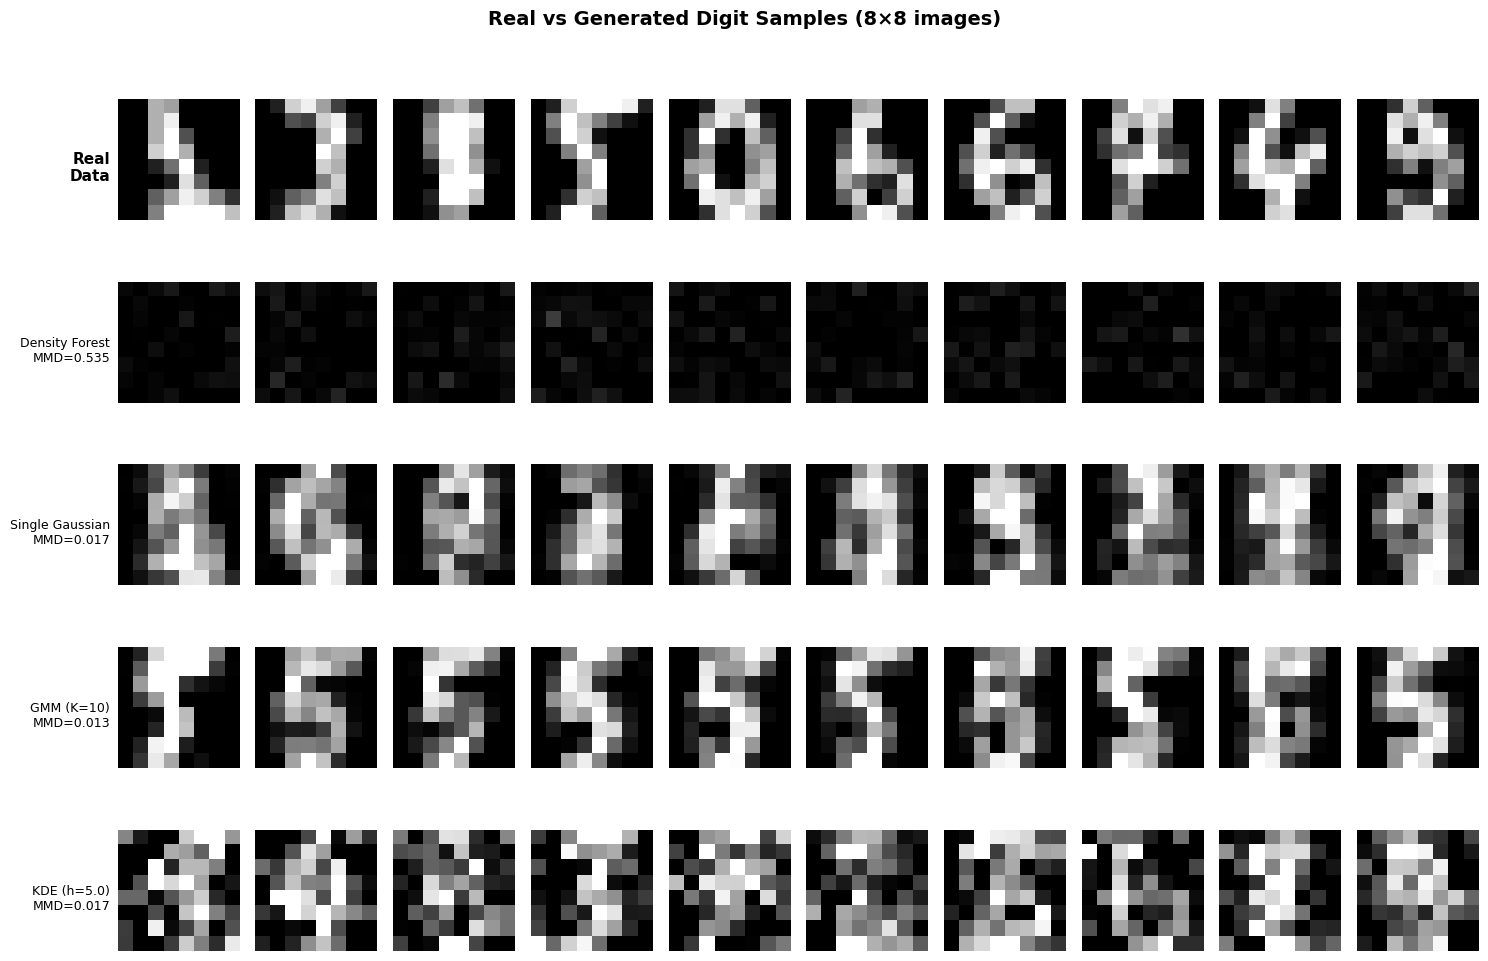


Comparing pixel value distributions...


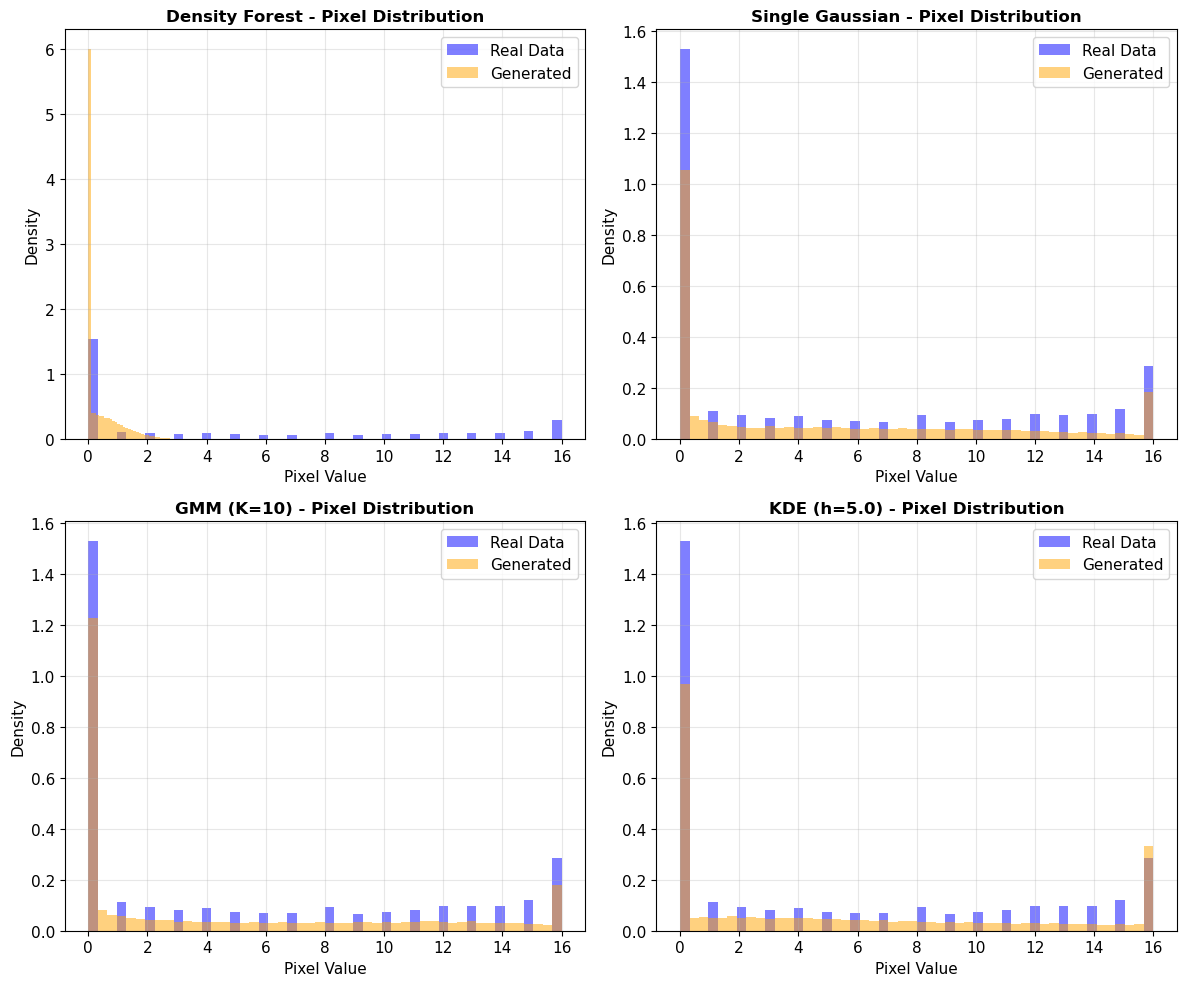

In [5]:
def visualize_generated_digits(results_list, X_real, n_samples=10):
    """
    Visualize generated digit samples as 8x8 images
    """
    n_models = len(results_list)
    fig, axes = plt.subplots(n_models + 1, n_samples, figsize=(15, 2*(n_models+1)))
    
    # Row 0: Real test samples
    for j in range(n_samples):
        img = X_real[j].reshape(8, 8)
        axes[0, j].imshow(img, cmap='gray', vmin=0, vmax=16)
        axes[0, j].axis('off')
        if j == 0:
            axes[0, j].text(-1, 4, 'Real\nData', 
                          fontsize=11, fontweight='bold',
                          ha='right', va='center')
    
    # Other rows: Generated samples
    for i, result in enumerate(results_list):
        for j in range(n_samples):
            img = result['samples'][j].reshape(8, 8)
            # Clip to valid range [0, 16]
            img = np.clip(img, 0, 16)
            axes[i+1, j].imshow(img, cmap='gray', vmin=0, vmax=16)
            axes[i+1, j].axis('off')
            if j == 0:
                label = f"{result['model']}\nMMD={result['mmd_se']:.3f}"
                axes[i+1, j].text(-1, 4, label, 
                                fontsize=9,
                                ha='right', va='center')
    
    plt.suptitle('Real vs Generated Digit Samples (8×8 images)', 
                 fontsize=14, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()

# Visualize
visualize_generated_digits(results, X_test, n_samples=10)



# Pixel value distribution comparison
print("\nComparing pixel value distributions...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, result in enumerate(results):
    X_gen = np.clip(result['samples'], 0, 16)
    
    axes[i].hist(X_test.flatten(), bins=50, alpha=0.5, 
                label='Real Data', density=True, color='blue')
    axes[i].hist(X_gen.flatten(), bins=50, alpha=0.5, 
                label='Generated', density=True, color='orange')
    axes[i].set_xlabel('Pixel Value', fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f"{result['model']} - Pixel Distribution", 
                     fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Recognizability Check

RECOGNIZABILITY CHECK

[Step 1] Training RandomForestClassifier on real digits...
✓ Classifier trained
  Accuracy on real test data: 0.9667 (96.67%)
  → This classifier can recognize real digits well!

[Step 2] Evaluating Generated Samples

Density Forest:
--------------------------------------------------
  Generated 500 samples

  Predicted digit distribution:
    Digit 0:   0 (  0.0%) 
    Digit 1:   2 (  0.4%) 
    Digit 2:   0 (  0.0%) 
    Digit 3:   5 (  1.0%) 
    Digit 4:   6 (  1.2%) 
    Digit 5: 456 ( 91.2%) █████████████████████████████████████████████
    Digit 6:   0 (  0.0%) 
    Digit 7:  25 (  5.0%) ██
    Digit 8:   0 (  0.0%) 
    Digit 9:   6 (  1.2%) 

  ⚠️  Missing digits: [0, 2, 6, 8]
  KL divergence from uniform: 1.8945
    (0 = perfect uniform, lower is better)
  Balance score: 0.3000 (1.0 = perfect)
  Overall recognizability: 0.4500

Single Gaussian:
--------------------------------------------------
  Generated 500 samples

  Predicted digit distribution:
  

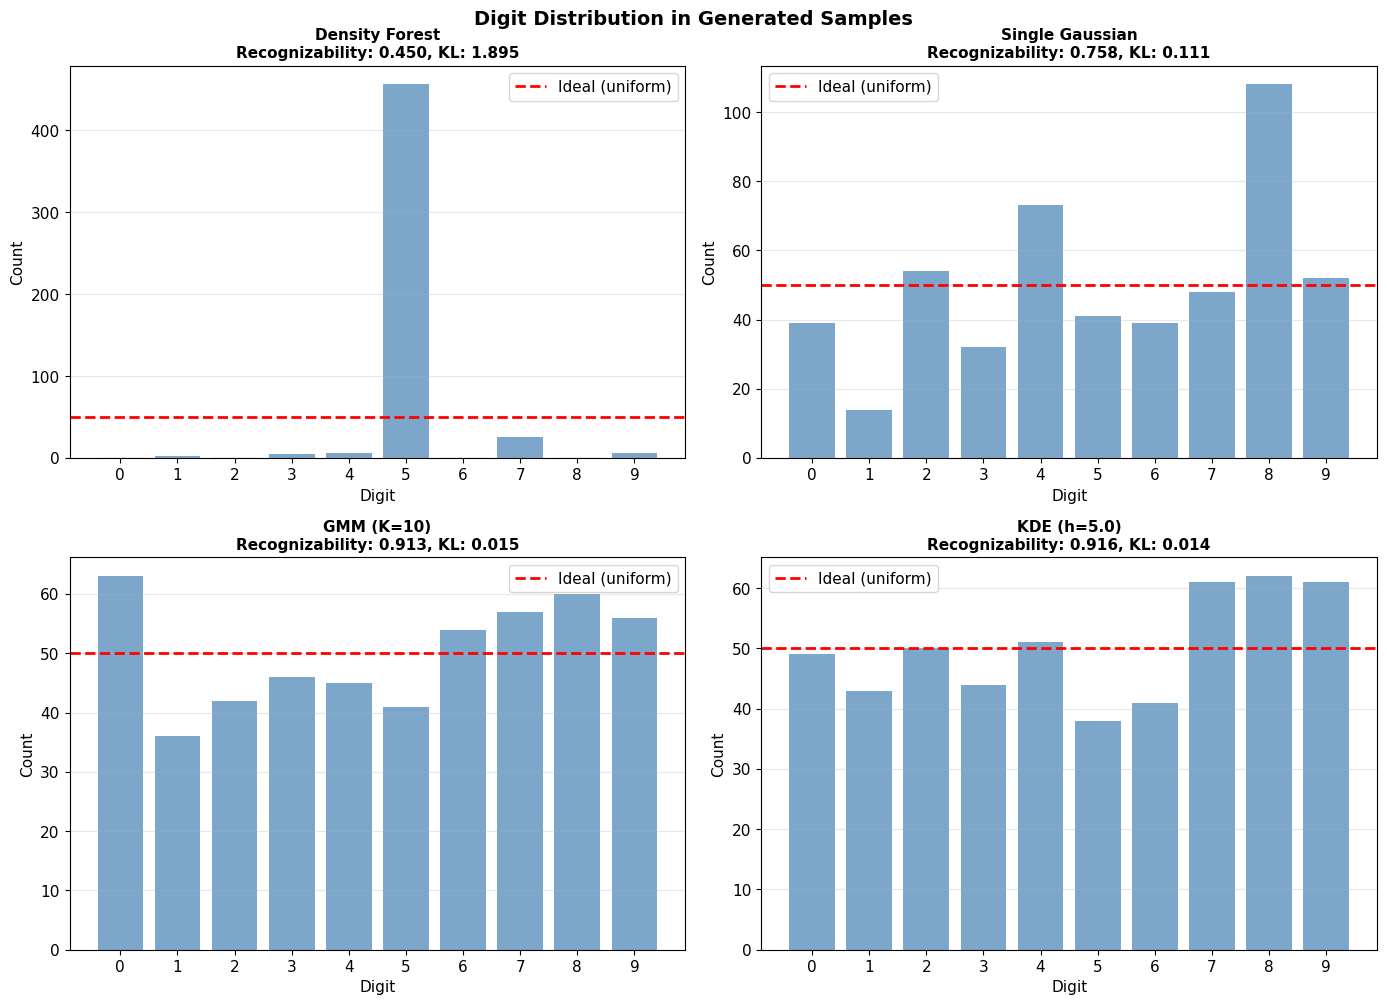

In [6]:
print("="*70)
print("RECOGNIZABILITY CHECK")
print("="*70)

# Train classifier on real data
print("\n[Step 1] Training RandomForestClassifier on real digits...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Test on real test set
y_pred_real = clf.predict(X_test)
acc_real = accuracy_score(y_test, y_pred_real)
print(f"✓ Classifier trained")
print(f"  Accuracy on real test data: {acc_real:.4f} ({acc_real*100:.2f}%)")
print(f"  → This classifier can recognize real digits well!")



# Evaluate recognizability of generated samples
print("\n" + "="*70)
print("[Step 2] Evaluating Generated Samples")
print("="*70)

recognizability_results = []

for result in results:
    model_name = result['model']
    X_generated = result['samples']
    
    print(f"\n{model_name}:")
    print("-" * 50)
    
    # IMPORTANT: Clip values to valid range [0, 16]
    X_gen_clipped = np.clip(X_generated, 0, 16)
    
    # Predict digits
    y_pred = clf.predict(X_gen_clipped)
    
    # Analyze distribution
    unique, counts = np.unique(y_pred, return_counts=True)
    distribution = dict(zip(unique, counts))
    
    print(f"  Generated {len(y_pred)} samples")
    print(f"\n  Predicted digit distribution:")
    for digit in range(10):
        count = distribution.get(digit, 0)
        percentage = count / len(y_pred) * 100
        bar = '█' * int(percentage / 2)
        print(f"    Digit {digit}: {count:3d} ({percentage:5.1f}%) {bar}")
    
    # Check completeness
    missing_digits = set(range(10)) - set(unique)
    if missing_digits:
        print(f"\n  ⚠️  Missing digits: {sorted(missing_digits)}")
        completeness = len(unique) / 10
    else:
        print(f"\n  ✓  All 10 digits generated!")
        completeness = 1.0
    
    # Check uniformity (KL divergence)
    ideal_dist = np.ones(10) / 10
    actual_dist = np.zeros(10)
    for digit, count in distribution.items():
        actual_dist[digit] = count / len(y_pred)
    
    kl_div = entropy(actual_dist + 1e-10, ideal_dist + 1e-10)
    print(f"  KL divergence from uniform: {kl_div:.4f}")
    print(f"    (0 = perfect uniform, lower is better)")
    
    # Balance score
    if len(unique) == 10:
        proportions = counts / len(y_pred)
        balance = 1 - np.std(proportions) / 0.1
        balance = max(0, balance)
    else:
        balance = 0.5 * (len(unique) / 10)
    
    print(f"  Balance score: {balance:.4f} (1.0 = perfect)")
    
    # Overall score
    recognizability = (completeness + balance) / 2
    print(f"  Overall recognizability: {recognizability:.4f}")
    
    recognizability_results.append({
        'model': model_name,
        'distribution': distribution,
        'n_unique': len(unique),
        'missing': missing_digits,
        'kl_div': kl_div,
        'completeness': completeness,
        'balance': balance,
        'recognizability': recognizability
    })


# Summary table
print("\n" + "="*70)
print("RECOGNIZABILITY SUMMARY")
print("="*70)
print(f"{'Model':<25} {'Unique':<8} {'KL Div':<10} {'Complete':<10} {'Balance':<10} {'Overall':<10}")
print("-"*70)
for r in recognizability_results:
    print(f"{r['model']:<25} {r['n_unique']:<8} {r['kl_div']:<10.4f} "
          f"{r['completeness']:<10.4f} {r['balance']:<10.4f} {r['recognizability']:<10.4f}")
print("="*70)

best_recog = max(recognizability_results, key=lambda r: r['recognizability'])
print(f"\n✓ Best recognizability: {best_recog['model']} "
      f"(score = {best_recog['recognizability']:.4f})")


# Visualize recognizability
print("\nVisualizing recognizability results...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, r in enumerate(recognizability_results):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Bar plot
    digits = list(range(10))
    counts = [r['distribution'].get(d, 0) for d in digits]
    
    bars = ax.bar(digits, counts, alpha=0.7, color='steelblue')
    ax.axhline(y=len(results[i]['samples'])/10, color='r', 
               linestyle='--', label='Ideal (uniform)', linewidth=2)
    
    # Highlight missing
    for d in r['missing']:
        bars[d].set_color('red')
        bars[d].set_alpha(0.3)
    
    ax.set_xlabel('Digit', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f"{r['model']}\n"
                f"Recognizability: {r['recognizability']:.3f}, "
                f"KL: {r['kl_div']:.3f}",
                fontsize=11, fontweight='bold')
    ax.set_xticks(digits)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Digit Distribution in Generated Samples', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()   

### Summary and Discussion (High-D)

In [7]:
summary = f"""
{'='*70}
PART 2 SUMMARY: HIGH-DIMENSIONAL DATA (64D)
{'='*70}

1. PERFORMANCE COMPARISON (MMD)
{'─'*70}
"""

# Sort by MMD
sorted_results = sorted(results, key=lambda r: r['mmd_se'])
summary += "\nModel Rankings by MMD (SE kernel, h=10.0):\n"
for i, r in enumerate(sorted_results, 1):
    summary += f"  {i}. {r['model']:<25} MMD: {r['mmd_se']:.4f}\n"

summary += "\n2. RECOGNIZABILITY COMPARISON\n"
summary += "─"*70 + "\n"

# Sort by recognizability
sorted_recog = sorted(recognizability_results, 
                     key=lambda r: r['recognizability'], reverse=True)
summary += "\nModel Rankings by Recognizability:\n"
for i, r in enumerate(sorted_recog, 1):
    summary += f"  {i}. {r['model']:<25} Score: {r['recognizability']:.4f}\n"

summary += f"""

3. KEY OBSERVATIONS
{'─'*70}

Curse of Dimensionality:
  • In 64D, data points are much more sparse than in 2D
  • Simple histograms don't work → need DensityForest
  • Larger kernel bandwidths needed (h=10 vs h=1)

MMD vs Recognizability Trade-off:
  • Low MMD ≠ automatically good recognizability
  • Some models fit statistics well but generate poor samples
  • Need BOTH metrics for complete evaluation

Best Model: {sorted_results[0]['model']}
  • Best MMD: {sorted_results[0]['mmd_se']:.4f}
  • Recognizability: {[r for r in recognizability_results if r['model']==sorted_results[0]['model']][0]['recognizability']:.4f}

Most Recognizable: {sorted_recog[0]['model']}
  • Recognizability: {sorted_recog[0]['recognizability']:.4f}
  • MMD: {[r for r in results if r['model']==sorted_recog[0]['model']][0]['mmd_se']:.4f}


4. RECOMMENDATIONS
{'─'*70}

For high-dimensional density estimation:
  ✓ Use DensityForest instead of Histogram
  ✓ Increase model capacity (GMM K=10-20 for digits)
  ✓ Use larger kernel bandwidths (h=10 for 64D)
  ✓ ALWAYS check recognizability, not just MMD!
  ✓ Visualize generated samples
  ✓ Test on multiple datasets

{'='*70}
"""

print(summary)


PART 2 SUMMARY: HIGH-DIMENSIONAL DATA (64D)

1. PERFORMANCE COMPARISON (MMD)
──────────────────────────────────────────────────────────────────────

Model Rankings by MMD (SE kernel, h=10.0):
  1. GMM (K=10)                MMD: 0.0134
  2. Single Gaussian           MMD: 0.0174
  3. KDE (h=5.0)               MMD: 0.0174
  4. Density Forest            MMD: 0.5345

2. RECOGNIZABILITY COMPARISON
──────────────────────────────────────────────────────────────────────

Model Rankings by Recognizability:
  1. KDE (h=5.0)               Score: 0.9165
  2. GMM (K=10)                Score: 0.9133
  3. Single Gaussian           Score: 0.7579
  4. Density Forest            Score: 0.4500


3. KEY OBSERVATIONS
──────────────────────────────────────────────────────────────────────

Curse of Dimensionality:
  • In 64D, data points are much more sparse than in 2D
  • Simple histograms don't work → need DensityForest
  • Larger kernel bandwidths needed (h=10 vs h=1)

MMD vs Recognizability Trade-off:
  •